In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [24]:
sns.set(color_codes=True)

## Dataset
Hơn 20 000 ván đấu cờ vua online trên hệ thống Lichess.org bao gồm các nước đi, rating, khai cuộc,...

In [2]:
games_df = pd.read_csv('games.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 1.6+ MB


In [3]:
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


<AxesSubplot:xlabel='average_rating'>

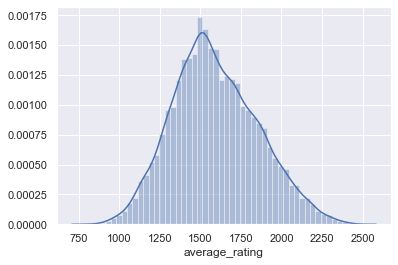

In [114]:
games_df['average_rating'] = (games_df['white_rating']+games_df['black_rating'])//2
sns.distplot(games_df['average_rating'])

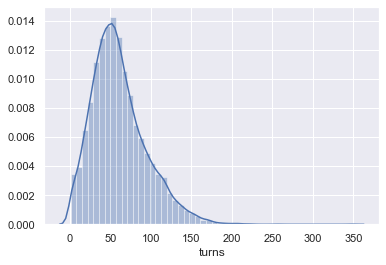

In [196]:
sns.distplot(games_df['turns'])
plt.show()

In [ ]:
sns.scatterplot(data=games_df,x = 'average_rating')

## Top 20 khai cuộc thông dụng nhất

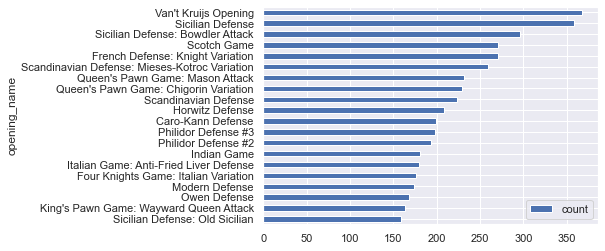

In [202]:
#top_20_common_opening = 
games_df.groupby(['opening_name'])['opening_name'].agg(['count']).sort_values(by = 'count',ascending = False).head(20).sort_values(by = 'count',ascending = True).plot(kind ='barh')#.sort_values(ascending = False).head(20)
#top_20_common_opening_df.plot.barh()
plt.show()

### Tỉ lệ thắng của các bên

In [217]:
winner_by_opening_df_uns = winner_by_opening_df.unstack().dropna()
winner_by_opening_df_uns['sum']=winner_by_opening_df_uns['black']+winner_by_opening_df_uns['white']+winner_by_opening_df_uns['draw']
winner_by_opening_df_uns['black_winrate']= winner_by_opening_df_uns['black']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['white_winrate']= winner_by_opening_df_uns['white']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['draw_rate']= winner_by_opening_df_uns['draw']/winner_by_opening_df_uns['sum']*100
winrate_by_opening_df = winner_by_opening_df_uns.sort_values(by = 'sum',ascending=False).head(20)[['black_winrate','white_winrate','draw_rate']]
cm = sns.light_palette("green", as_cmap=True)
winrate_by_opening_df.style.background_gradient(cmap=cm)

winner,black_winrate,white_winrate,draw_rate
opening_name,,,
Van't Kruijs Opening,61.413043,34.239130,4.347826
Sicilian Defense,54.189944,41.620112,4.189944
Sicilian Defense: Bowdler Attack,55.405405,40.202703,4.391892
French Defense: Knight Variation,44.649446,49.815498,5.535055
Scotch Game,42.435424,53.505535,4.059041
Scandinavian Defense: Mieses-Kotroc Variation,34.362934,63.320463,2.316602
Queen's Pawn Game: Mason Attack,44.396552,50.000000,5.603448
Queen's Pawn Game: Chigorin Variation,47.598253,48.908297,3.493450
Scandinavian Defense,55.156951,40.358744,4.484305


### Những khai cuộc và số lượt đi trung bình trong ván đấu

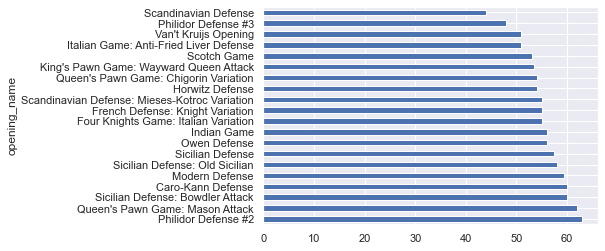

In [226]:
top_30_count_opening_average_moves_df = games_df.groupby('opening_name')['turns'].agg([np.median,'count']).sort_values(by = ['count'],ascending = [False]).head(20)
top_30_count_opening_average_moves_df['median'].sort_values(ascending = False).plot(kind = 'barh')
plt.show()

In [ ]:
Dễ dàng thấy được Scandinavian Defense là khai cuộc mà trận đấu kết thúc nhanh nhất

In [13]:
black_wins_games_df = games_df[games_df['winner']=='black']
white_wins_games_df = games_df[games_df['winner']=='white']
draw_games_df = games_df[games_df['winner']=='draw']

In [183]:
white_wins_games_df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,num_moves
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,13
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,61
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,61
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,95
6,qwU9rasv,True,1.504230e+12,1.504230e+12,33,resign,white,10+0,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20050,nYOvevdh,True,1.499814e+12,1.499814e+12,9,outoftime,white,10+0,jamboger,1243,yamaguchipolgar,1142,c4 e5 d4 exd4 Qxd4 Nf6 Bg5 Be7 e4,A20,English Opening: King's English Variation,2,9
20052,EopEqqAa,True,1.499812e+12,1.499812e+12,37,resign,white,10+10,jamboger,1219,samael88,1250,c4 e6 d4 b6 Nc3 Bb7 Nf3 g6 h4 Bg7 Bg5 f6 Bf4 d...,A40,English Defense,4,37
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,24
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,35
